In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import r2_score

import ROOT
from ROOT import TLorentzVector, TVector3

#from eval_model import eval_model, eval_plots
from new_model import *
from DataLoader_Parallel import CustomDataset

import uproot
import awkward as ak
import vector

import mplhep as mh
import hist

Welcome to JupyROOT 6.28/06


In [2]:
L_eval_dataset = "WS_L_1M/datasets_fullBoost/dataset_combined.pt"
R_eval_dataset = "WS_R_1M/datasets_fullBoost/dataset_combined.pt"

in_model = "WS_U_10M/training_Default_Tasks_Boosted_Frame_120epoch_64embed/model_final.torch"
#in_model = "WS_U_10M/training_All_Task_Boost_tRest_Bottom_cosSim_v2_140epoch_64embed/models/model_Epoch_140.torch"

In [3]:
L_dataset = torch.load(L_eval_dataset, weights_only=False)
R_dataset = torch.load(R_eval_dataset, weights_only=False)

model = torch.load(in_model, weights_only=False)

In [4]:
with uproot.open("../pythia/WS_R_1M/combined.root:fastjet") as f:
    probe_jet_pt_R = f["probe_jet_pT"].array()
    probe_jet_eta_R = f["probe_jet_eta"].array()
    probe_jet_phi_R = f["probe_jet_phi"].array()
    
    top_px_R = f["top_px_lab"].array()
    top_py_R = f["top_py_lab"].array()
    top_pz_R = f["top_pz_lab"].array()
    
    bottom_px_R = f["bottom_px_lab"].array()
    bottom_py_R = f["bottom_py_lab"].array()
    bottom_pz_R = f["bottom_pz_lab"].array()
    bottom_energy_R = f["bottom_e_boost_tRest"].array()
    
with uproot.open("../pythia/WS_L_1M/combined.root:fastjet") as f:
    probe_jet_pt_L = f["probe_jet_pT"].array()
    probe_jet_eta_L = f["probe_jet_eta"].array()
    probe_jet_phi_L = f["probe_jet_phi"].array()
    
    top_px_L = f["top_px_lab"].array()
    top_py_L = f["top_py_lab"].array()
    top_pz_L = f["top_pz_lab"].array()
    
    bottom_px_L = f["bottom_px_lab"].array()
    bottom_py_L = f["bottom_py_lab"].array()
    bottom_pz_L = f["bottom_pz_lab"].array()
    bottom_energy_L = f["bottom_e_boost_tRest"].array()

In [5]:
probe_jet_R = vector.array({"pt": probe_jet_pt_R, "eta": probe_jet_eta_R, "phi": probe_jet_phi_R})
top_R = vector.array({"px": top_px_R, "py": top_py_R, "pz": top_pz_R})
bottom_R = vector.array({"px": bottom_px_R, "py": bottom_py_R, "pz": bottom_pz_R})

In [6]:
probe_jet_L = vector.array({"pt": probe_jet_pt_L, "eta": probe_jet_eta_L, "phi": probe_jet_phi_L})
top_L = vector.array({"px": top_px_L, "py": top_py_L, "pz": top_pz_L})
bottom_L = vector.array({"px": bottom_px_L, "py": bottom_py_L, "pz": bottom_pz_L})

In [7]:
deltaR_R = probe_jet_R.deltaR(top_R)
deltaR_L = probe_jet_L.deltaR(top_L)

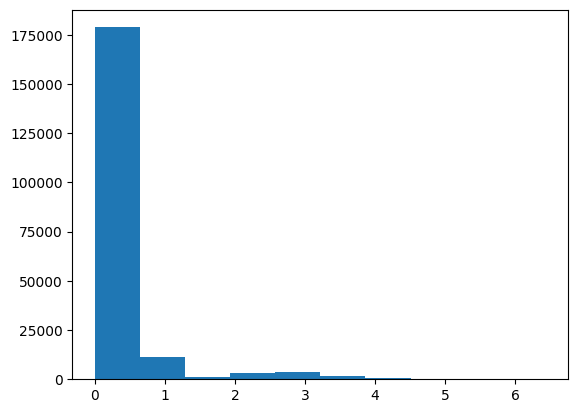

In [8]:
plt.hist(deltaR_R)
#plt.yscale("log")
plt.show()

In [9]:
bottom_deltaR_R = top_R.deltaR(bottom_R)
bottom_deltaR_L = top_L.deltaR(bottom_L)

bottom_jet_deltaR_R = probe_jet_R.deltaR(bottom_R)
bottom_jet_deltaR_L = probe_jet_L.deltaR(bottom_L)

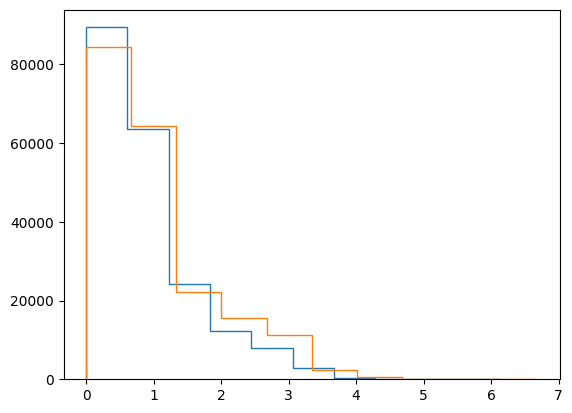

In [10]:
plt.hist(bottom_deltaR_R,histtype='step')
plt.hist(bottom_jet_deltaR_R,histtype='step')
plt.show()

In [11]:
COS_THETA_L = []
for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in L_dataset:
    COS_THETA_L.append(direct_labels[1])
COS_THETA_R = []
for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in R_dataset:
    COS_THETA_R.append(direct_labels[1])

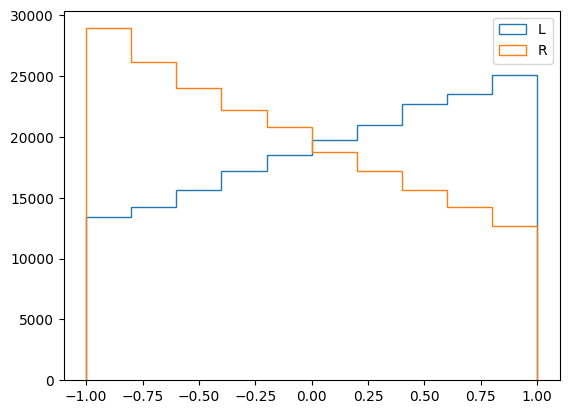

191080
200623


In [12]:
plt.hist(COS_THETA_L,label='L',histtype='step')
plt.hist(COS_THETA_R,label='R',histtype='step')
plt.legend()
plt.show()
print(len(COS_THETA_L))
print(len(COS_THETA_R))

In [13]:
batch_size=128
L_loader = DataLoader(L_dataset, batch_size=batch_size)
R_loader = DataLoader(R_dataset, batch_size=batch_size)

In [14]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [15]:
def calc_norm(y_pred):
    norm = torch.sqrt(torch.sum(torch.square(y_pred), dim=1)).reshape(-1,1)
    y_pred_norm = torch.div(y_pred, norm)
    return y_pred_norm

In [16]:
top_feats=4
pred_top_L = np.array([]).reshape(0,top_feats)
true_top_L = np.array([]).reshape(0,top_feats)

down_feats=3
pred_down_L = np.array([]).reshape(0,down_feats)
true_down_L = np.array([]).reshape(0,down_feats)

direct_feats=1
pred_direct_L = np.array([]).reshape(0,direct_feats)
true_direct_L = np.array([]).reshape(0,direct_feats)

for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in L_loader:
    top_pred, down_pred, direct_pred, track_pred = model(probe_jet.to(device), constituents.to(device), event.to(device))

    #down_pred = torch.tanh(down_pred)
    down_pred = calc_norm(down_pred)
    
    pred_top_L = np.vstack((pred_top_L,top_pred.detach().cpu().numpy()))
    true_top_L = np.vstack((true_top_L,top_labels.detach().cpu().numpy()))

    pred_down_L = np.vstack((pred_down_L,down_pred.detach().cpu().numpy()))
    true_down_L = np.vstack((true_down_L,down_labels.detach().cpu().numpy()))
    
    #pred_direct_L = np.vstack((pred_direct_L,direct_pred.detach().cpu().numpy()))
    #true_direct_L = np.vstack((true_direct_L,direct_labels[:,1].reshape(-1,1).detach().cpu().numpy()))

In [17]:
top_feats=4
pred_top_R = np.array([]).reshape(0,top_feats)
true_top_R = np.array([]).reshape(0,top_feats)

down_feats=3
pred_down_R = np.array([]).reshape(0,down_feats)
true_down_R = np.array([]).reshape(0,down_feats)

direct_feats=1
pred_direct_R = np.array([]).reshape(0,direct_feats)
true_direct_R = np.array([]).reshape(0,direct_feats)

for probe_jet, constituents, event, top_labels, down_labels, bottom_labels, direct_labels, track_labels in R_loader:
    top_pred, down_pred, direct_pred, track_pred = model(probe_jet.to(device), constituents.to(device), event.to(device))

    #down_pred = torch.tanh(down_pred)
    down_pred = calc_norm(down_pred)
    
    pred_top_R = np.vstack((pred_top_R,top_pred.detach().cpu().numpy()))
    true_top_R = np.vstack((true_top_R,top_labels.detach().cpu().numpy()))

    pred_down_R = np.vstack((pred_down_R,down_pred.detach().cpu().numpy()))
    true_down_R = np.vstack((true_down_R,down_labels.detach().cpu().numpy()))

    #pred_direct_R = np.vstack((pred_direct_R,direct_pred.detach().cpu().numpy()))
    #true_direct_R = np.vstack((true_direct_R,direct_labels[:,1].reshape(-1,1).detach().cpu().numpy()))

In [18]:
def validate_predictions(true, pred, var_names):
    num_feats = len(var_names)
    ranges_dict = {"top_px": (-1000,1000),
                   "top_py": (-1000,1000),
                   "top_pz": (-1000,1000),
                   "top_e" : (0,1500),
                   "down_px": (-1.1,1.1),
                   "down_py": (-1.1,1.1),
                   "down_pz": (-1.1,1.1),
                   "bottom_px": (-1.1,1.1),
                   "bottom_py": (-1.1,1.1),
                   "bottom_pz": (-1.1,1.1),
                   "costheta": (-1.1,1.1)}

    if "top" in var_names[0]:
        num_plots = 4
        tag = "Top"
        fig1, axes1 = plt.subplots(2, num_plots, figsize=(24, 10))
    else:
        num_plots = 3
        tag = "Bottom"
        fig1, axes1 = plt.subplots(2, num_plots, figsize=(16, 10))
        
    axes1 = axes1.flatten()

    for i ,var in enumerate(var_names):
        var_range = ranges_dict[var]

        ax1 = axes1[i]
        n, bins, _ = ax1.hist(np.ravel(true[:,i]),histtype='step',color='r',label='True Distribution',bins=50,range=var_range)
        ax1.hist(np.ravel(pred[:,i]),histtype='step',color='b',label='Predicted Distribution',bins=50,range=var_range)
        ax1.set_title("1D Comparision "+var_names[i])
        ax1.legend()
        #ax1.set_yscale('log')
        ax1.set_xlabel(var_names[i],loc='right')
        ax1.set_ylim(1,1.2*max(n))

        #plt.figure()
        ax2 = axes1[i+num_plots]
        ax2.set_title("2D Comparision "+var_names[i])
        h = ax2.hist2d(np.ravel(pred[:,i]),np.ravel(true[:,i]), bins=100,norm=mcolors.LogNorm(),range=(var_range,var_range))
        #fig.colorbar(h[3], ax=ax)
        ax2.set_xlabel('Predicted '+var_names[i],loc='right')
        ax2.set_ylabel('True '+var_names[i],loc='top')
        diff = var_range[1] - var_range[0]
        ax2.text(var_range[1]-0.3*diff,var_range[0]+0.2*diff,"$R^2$ value: "+str(round(r2_score(np.ravel(true[:,i]),np.ravel(pred[:,i])),3)),backgroundcolor='r',color='k')
        #print("R^2 value: ", round(r2_score(true_labels[:,i],predicted_labels[:,i]),3))
        fig1.colorbar(h[3], ax=ax2)
    
    fig1.suptitle(tag+" Results: Ouput Distributions using Attention Model", fontsize=24)
    fig1.tight_layout()

    plt.show()

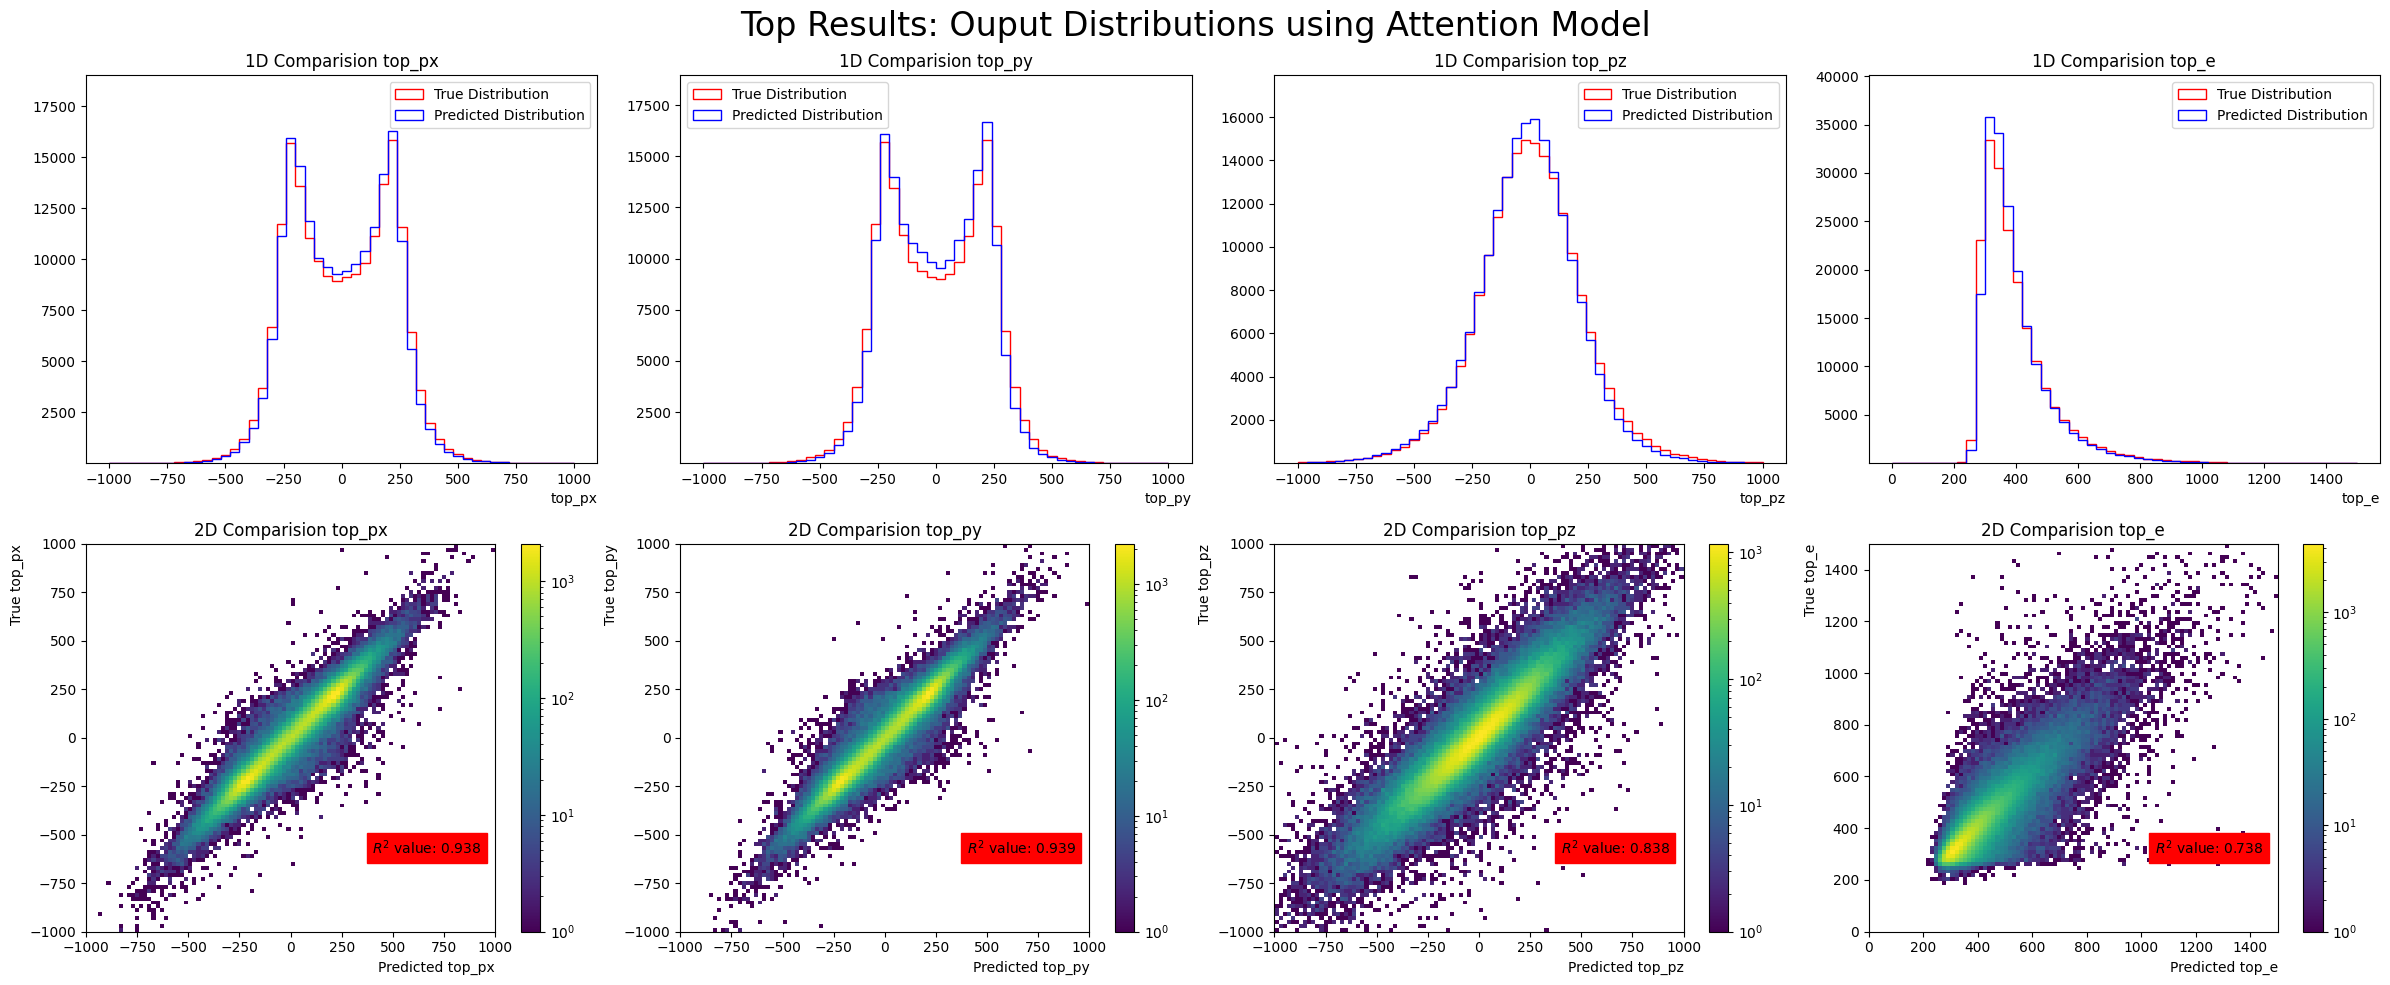

In [19]:
do_PlotTop=True
if do_PlotTop:
    validate_predictions(true_top_L, pred_top_L, ["top_px", "top_py", "top_pz", "top_e"])

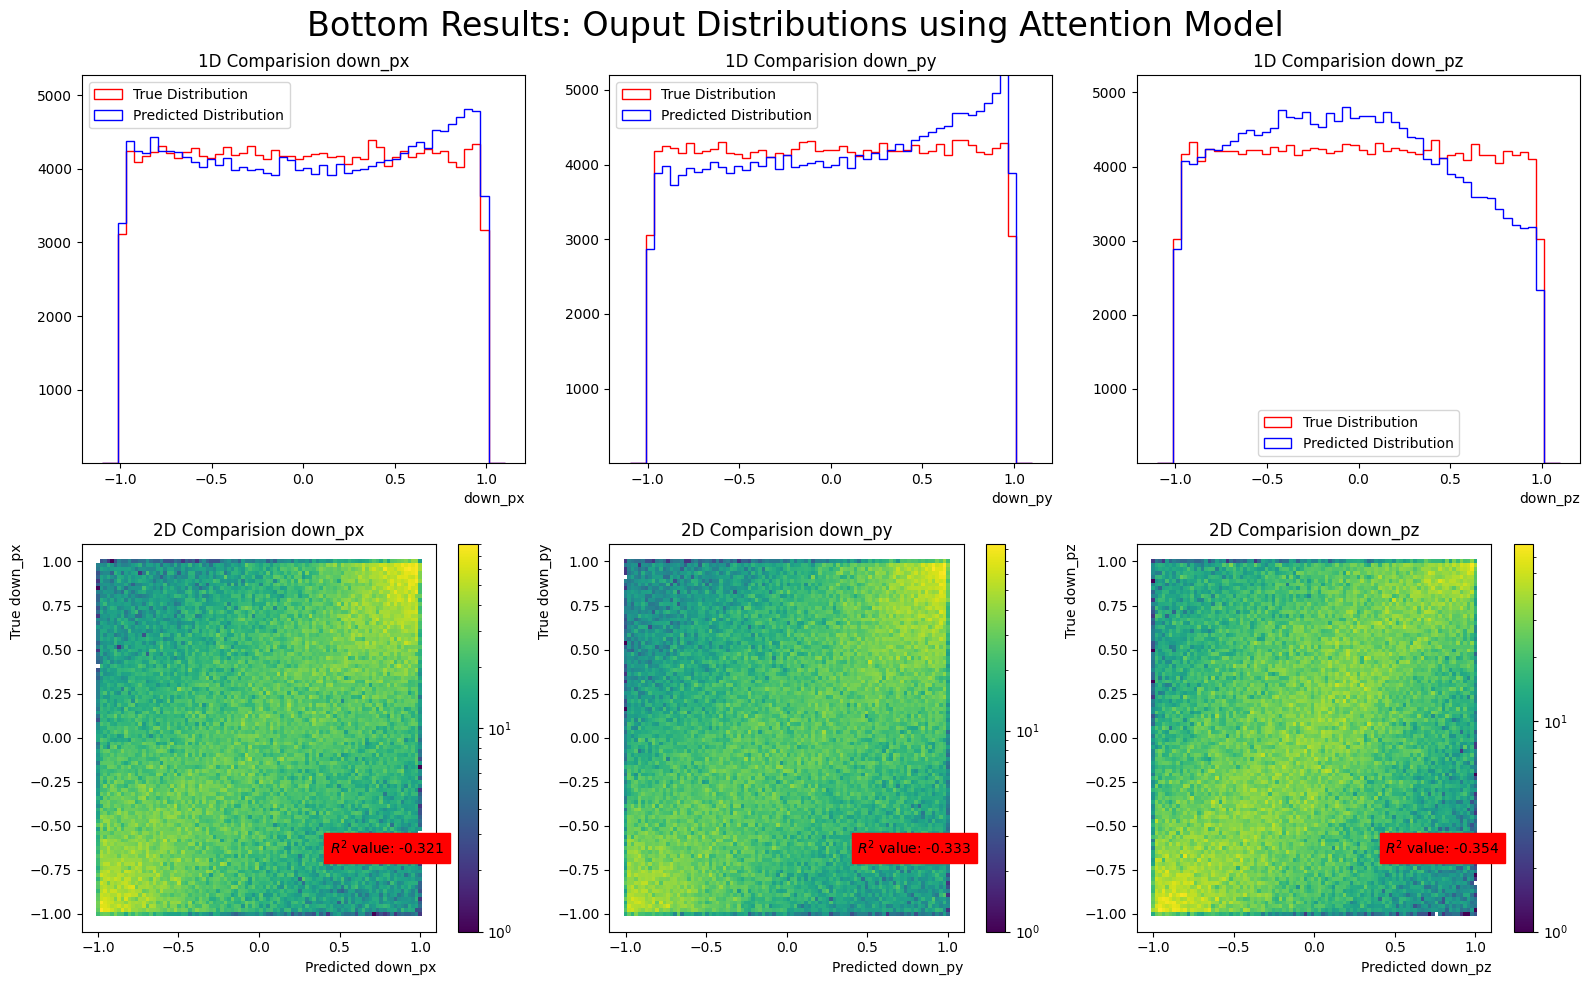

In [20]:
do_PlotDown=True
if do_PlotDown:
    validate_predictions(true_down_L, pred_down_L, ["down_px", "down_py", "down_pz"])

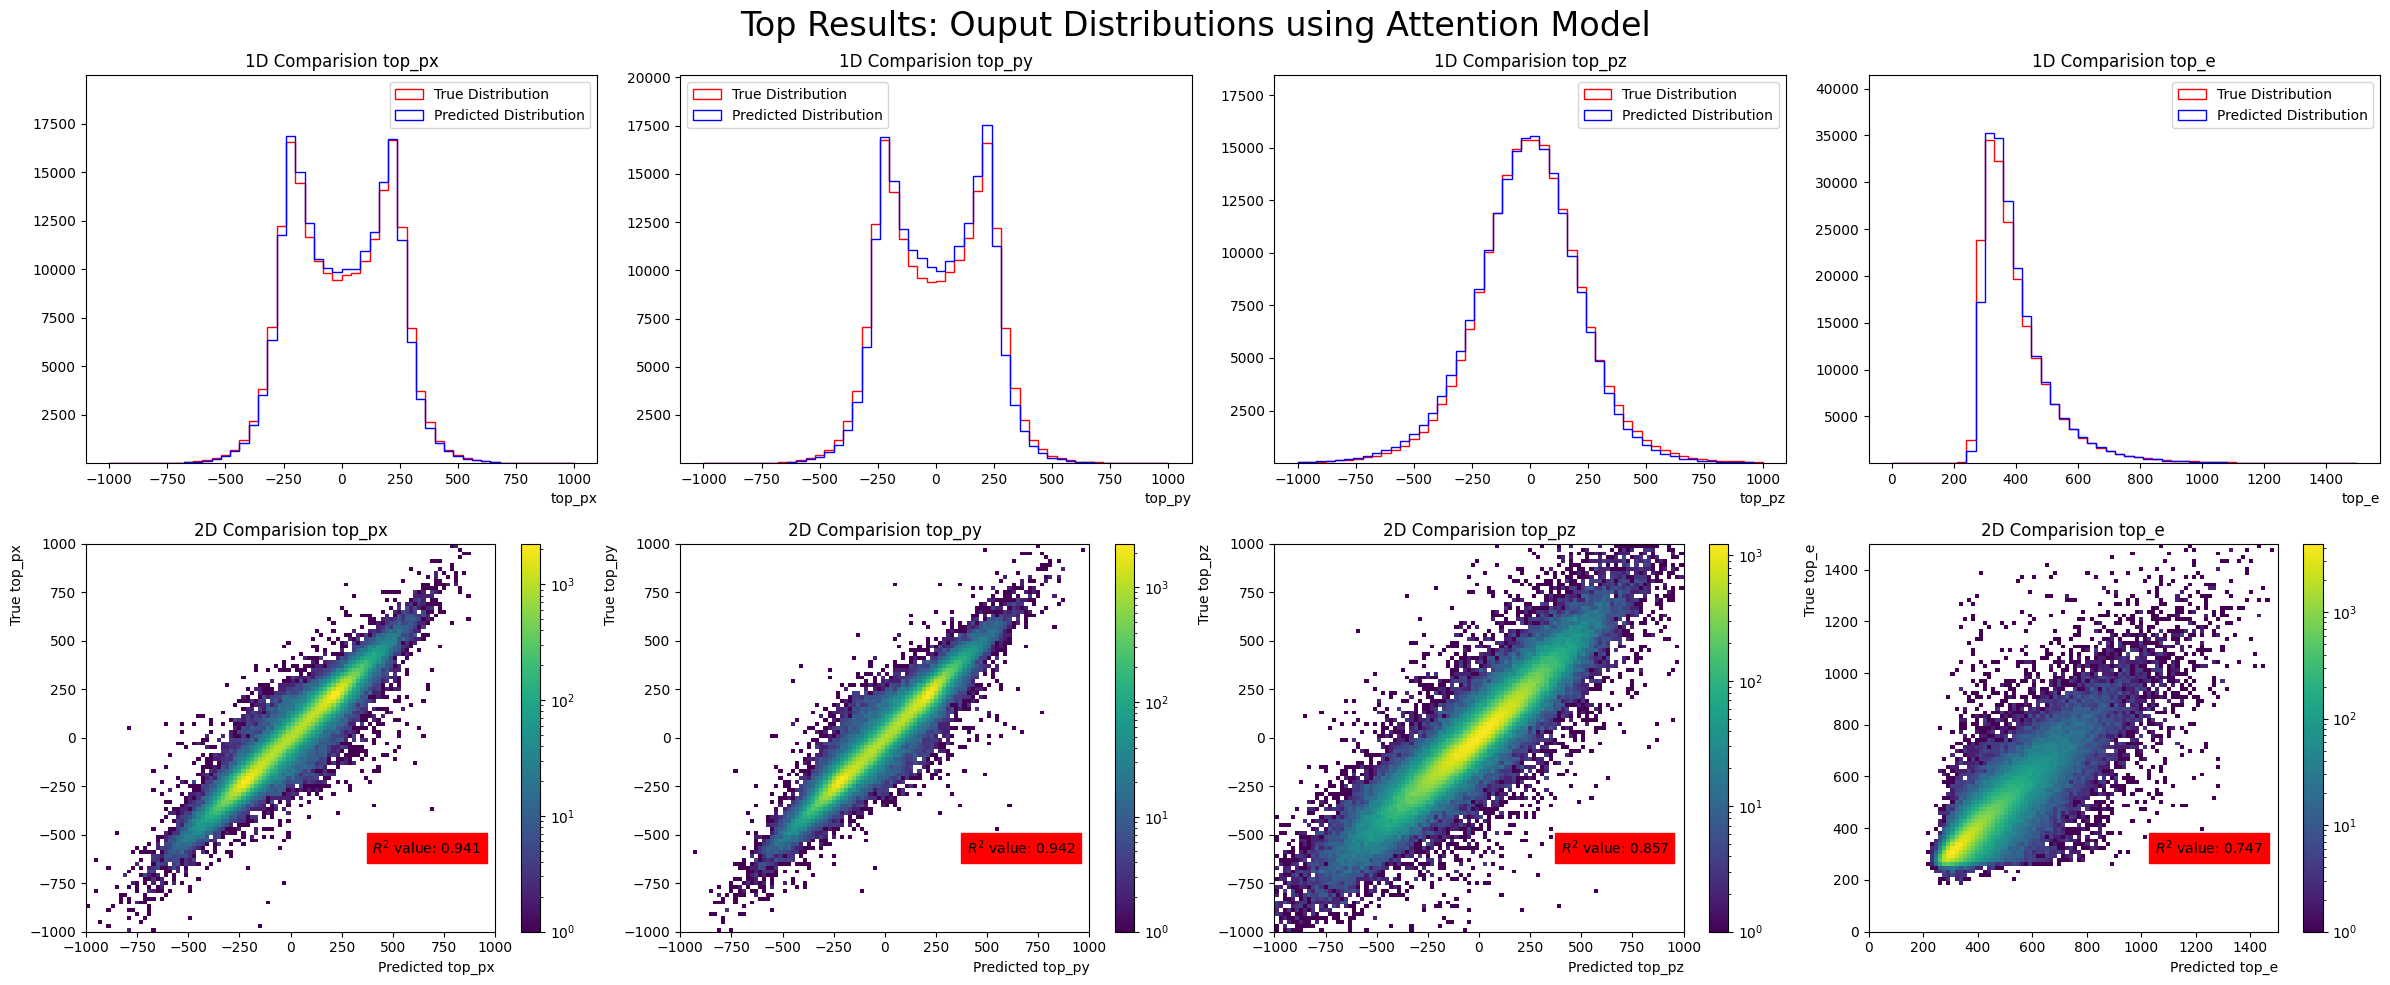

In [21]:
do_PlotTop=True
if do_PlotTop:
    validate_predictions(true_top_R, pred_top_R, ["top_px", "top_py", "top_pz", "top_e"])

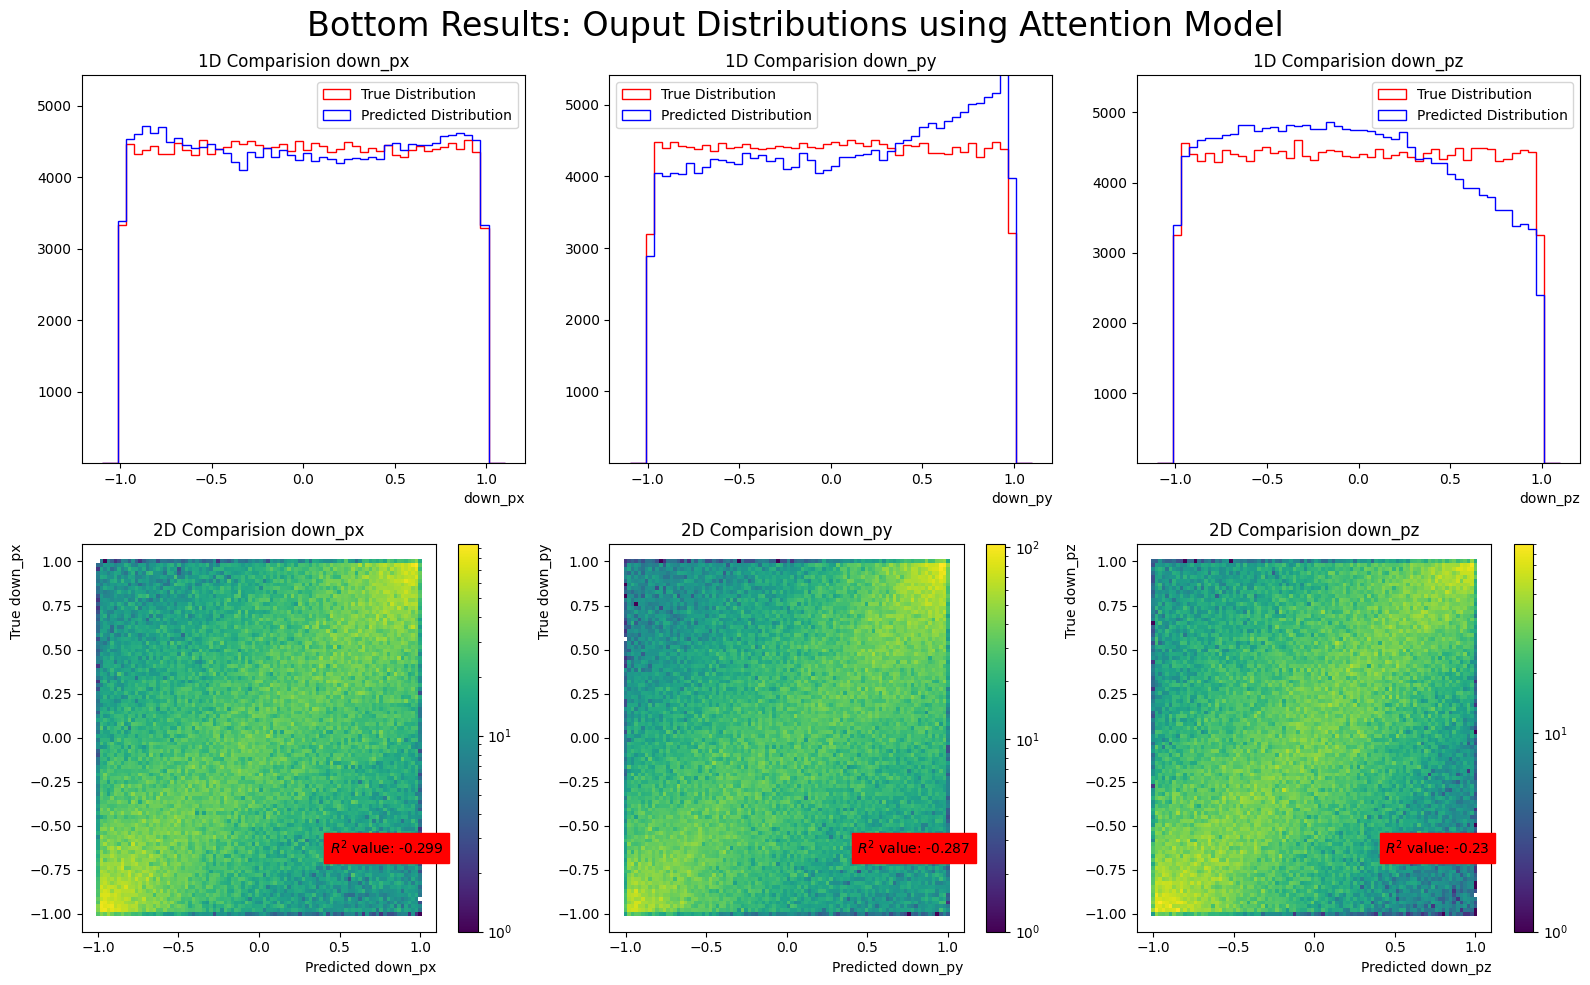

In [22]:
do_PlotDown=True
if do_PlotDown:
    validate_predictions(true_down_R, pred_down_R, ["down_px", "down_py", "down_pz"])

In [23]:
"""
cos_theta_true_L=[]
cos_theta_pred_L=[]

cos_similarity_L=[]

events = len(true_top_L)
for event in range(events):
    vec_top_true_L = TLorentzVector(true_top_L[event,0],true_top_L[event,1],true_top_L[event,2],true_top_L[event,3])
    vec_top_pred_L = TLorentzVector(pred_top_L[event,0],pred_top_L[event,1],pred_top_L[event,2],pred_top_L[event,3])
    vec_down_true_L = TVector3(true_down_L[event,0],true_down_L[event,1],true_down_L[event,2])
    vec_down_pred_L = TVector3(pred_down_L[event,0],pred_down_L[event,1],pred_down_L[event,2])
    
    vec_top_true_L = vec_top_true_L.Vect().Unit()
    vec_top_pred_L = vec_top_pred_L.Vect().Unit()
    
    cos_similarity_L.append(vec_down_true_L.Unit().Dot(vec_down_pred_L.Unit()))

    cos_theta_true_L.append(vec_top_true_L.Dot(vec_down_true_L))
    if post_norm:
        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L.Unit()))
    else:
        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L))
"""

'\ncos_theta_true_L=[]\ncos_theta_pred_L=[]\n\ncos_similarity_L=[]\n\nevents = len(true_top_L)\nfor event in range(events):\n    vec_top_true_L = TLorentzVector(true_top_L[event,0],true_top_L[event,1],true_top_L[event,2],true_top_L[event,3])\n    vec_top_pred_L = TLorentzVector(pred_top_L[event,0],pred_top_L[event,1],pred_top_L[event,2],pred_top_L[event,3])\n    vec_down_true_L = TVector3(true_down_L[event,0],true_down_L[event,1],true_down_L[event,2])\n    vec_down_pred_L = TVector3(pred_down_L[event,0],pred_down_L[event,1],pred_down_L[event,2])\n    \n    vec_top_true_L = vec_top_true_L.Vect().Unit()\n    vec_top_pred_L = vec_top_pred_L.Vect().Unit()\n    \n    cos_similarity_L.append(vec_down_true_L.Unit().Dot(vec_down_pred_L.Unit()))\n\n    cos_theta_true_L.append(vec_top_true_L.Dot(vec_down_true_L))\n    if post_norm:\n        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L.Unit()))\n    else:\n        cos_theta_pred_L.append(vec_top_pred_L.Dot(vec_down_pred_L))\n'

In [24]:
def get_results(true_top, pred_top, true_quark, pred_quark, apply_norm=True):
    cos_theta_true=[]
    cos_theta_pred=[]
    cos_similarity_top=[]
    cos_similarity_quark=[]

    events = len(true_top)
    for event in range(events):
        # Initiliaze 4-Vector for Top
        vec_top_true = TLorentzVector()
        vec_top_true.SetPxPyPzE(true_top[event,0],true_top[event,1],true_top[event,2],true_top[event,3])
        vec_top_pred = TLorentzVector()
        vec_top_pred.SetPxPyPzE(pred_top[event,0],pred_top[event,1],pred_top[event,2],pred_top[event,3])

        # Initialize 4-Vector for sub-quark
        #vec3_quark_true = TVector3(true_quark[event,0]*SF[event],true_quark[event,1]*SF[event],true_quark[event,2]*SF[event])
        #vec3_quark_pred = TVector3(pred_quark[event,0],pred_quark[event,1],pred_quark[event,2]).Unit()
        #vec3_quark_pred = TVector3(vec3_quark_pred.Px(),vec3_quark_pred.Py(),vec3_quark_pred.Pz())
        vec3_quark_true = TVector3(true_quark[event,0],true_quark[event,1],true_quark[event,2])
        vec3_quark_pred = TVector3(pred_quark[event,0],pred_quark[event,1],pred_quark[event,2])
        
        #vec_quark_true = TLorentzVector()
        #vec_quark_true.SetPtEtaPhiE(vec3_quark_true.Pt(),vec3_quark_true.Eta(),vec3_quark_true.Phi(),SF[event])
        #vec_quark_true.SetPtEtaPhiM(vec3_quark_true.Pt(),vec3_quark_true.Eta(),vec3_quark_true.Phi(),0.0)
        #vec_quark_pred = TLorentzVector()
        #vec_quark_pred.SetPtEtaPhiM(vec3_quark_pred.Pt(),vec3_quark_pred.Eta(),vec3_quark_pred.Phi(),0.0)

        # Calculate boost vector for top rest frame
        #to_t_rest_true = -vec_top_true.BoostVector()
        #to_t_rest_pred = -vec_top_pred.BoostVector()

        # Boost sub-quark to top rest frame
        #vec_quark_true.Boost(to_t_rest_true)
        #vec_quark_pred.Boost(to_t_rest_pred)
        
        # Unit vector for sub-quark
        d_vect_true = vec3_quark_true
        #d_vect_pred = vec_quark_pred.Vect().Unit()
        d_vect_pred = vec3_quark_pred

        
        # Unit vector for top quark
        k_vect_true = vec_top_true.Vect().Unit()
        k_vect_pred = vec_top_pred.Vect().Unit()

        # Calc cos theta and cos sim
        cos_similarity_top.append(k_vect_true.Dot(k_vect_pred))
        cos_similarity_quark.append(d_vect_true.Dot(d_vect_pred))

        cos_theta_true.append(k_vect_true.Dot(d_vect_true))
        cos_theta_pred.append(k_vect_pred.Dot(d_vect_pred))
            
    return np.array(cos_theta_true), np.array(cos_theta_pred), np.array(cos_similarity_top), np.array(cos_similarity_quark)

In [25]:
cos_theta_true_L, cos_theta_pred_L, cos_similarity_top_L, cos_similarity_quark_L = get_results(true_top_L, pred_top_L, true_down_L, pred_down_L)

In [26]:
cos_theta_true_R, cos_theta_pred_R, cos_similarity_top_R, cos_similarity_quark_R = get_results(true_top_R, pred_top_R, true_down_R, pred_down_R)

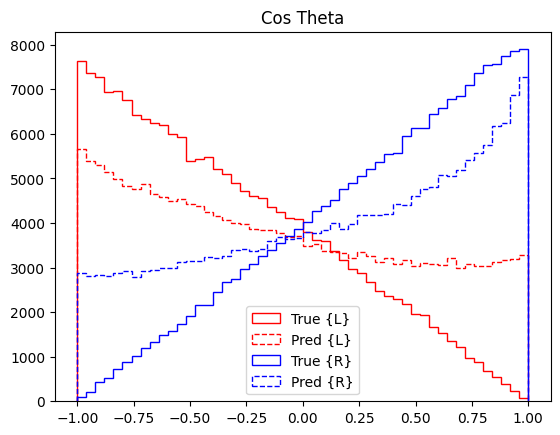

In [27]:
plt.title("Cos Theta")
plt.hist(cos_theta_true_L,histtype='step',bins=50,range=(-1,1),color='r',label='True {L}',linestyle="-")
plt.hist(cos_theta_pred_L,histtype='step',bins=50,range=(-1,1),color='r',label='Pred {L}',linestyle="--")
plt.hist(cos_theta_true_R,histtype='step',bins=50,range=(-1,1),color='b',label='True {R}',linestyle="-")
plt.hist(cos_theta_pred_R,histtype='step',bins=50,range=(-1,1),color='b',label='Pred {R}',linestyle="--")
plt.legend()
plt.show()

1.0


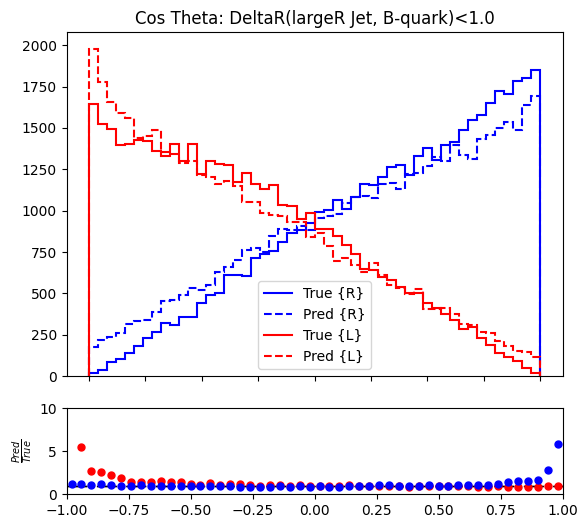

1.5


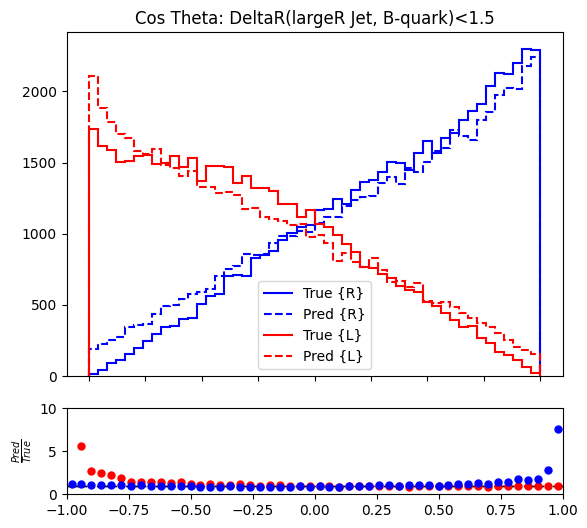

2.0


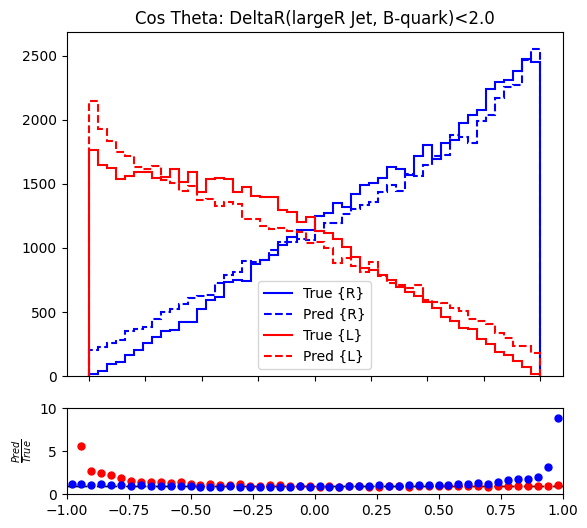

2.5


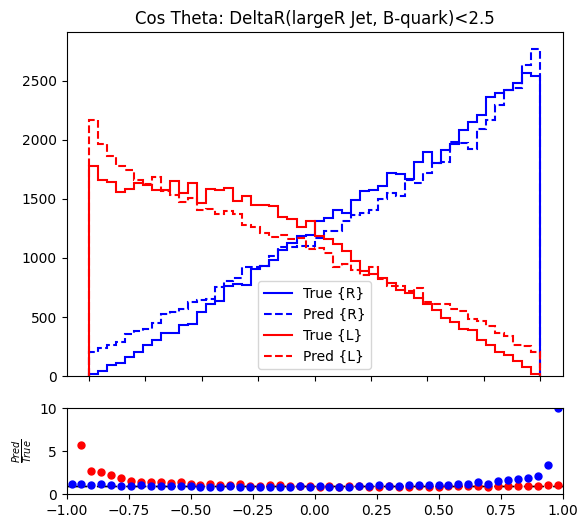

3.0


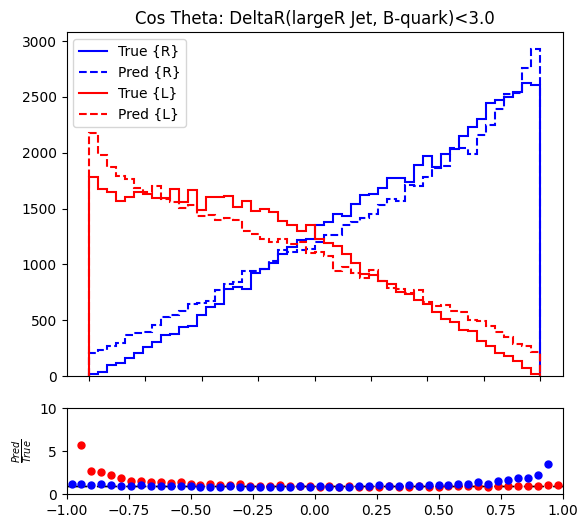

In [28]:
bottom_selection = [1+x*0.5 for x in range(5)]
for selection in bottom_selection:
    print(selection)
    mask1 = cos_similarity_quark_R>0.75
    mask2 = cos_similarity_top_R>0.75
    mask3 = bottom_deltaR_R<selection
    mask4 = deltaR_R<2.5
    good_R = mask1&mask2&mask3&mask4
    mask1 = cos_similarity_quark_L>0.75
    mask2 = cos_similarity_top_L>0.75
    mask3 = bottom_deltaR_L<selection
    mask4 = deltaR_L<2.5
    good_L = mask1&mask2&mask3&mask4
    cos_theta_pred_R_good = cos_theta_pred_R[good_R]
    cos_theta_pred_L_good = cos_theta_pred_L[good_L]
    cos_theta_true_R_good = cos_theta_true_R[good_R]
    cos_theta_true_L_good = cos_theta_true_L[good_L]
    #plt.title("Cos Theta")
    #plt.hist(cos_theta_pred_L_good,histtype='step',bins=50,range=(-1,1),color='r',label='Pred {L}',linestyle="--")
    #plt.hist(cos_theta_pred_R_good,histtype='step',bins=50,range=(-1,1),color='b',label='Pred {R}',linestyle="--")
    #plt.hist(cos_theta_true_L_good,histtype='step',bins=50,range=(-1,1),color='r',label='True {L}',linestyle="-")
    #plt.hist(cos_theta_true_R_good,histtype='step',bins=50,range=(-1,1),color='b',label='True {R}',linestyle="-")
    #plt.legend()
    #plt.show()
    
    fig, axes = mh.subplots(nrows=2)
    
    # Create and fill histograms
    h1 = hist.new.Regular(50, -1, 1).Weight().fill(cos_theta_true_R_good)
    h2 = hist.new.Regular(50, -1, 1).Weight().fill(cos_theta_pred_R_good)
    h3 = hist.new.Regular(50, -1, 1).Weight().fill(cos_theta_true_L_good)
    h4 = hist.new.Regular(50, -1, 1).Weight().fill(cos_theta_pred_L_good)
    
    mh.histplot(h1,ax=axes[0],color='b',linestyle='-',histtype='step',yerr=False,label="True {R}")
    mh.histplot(h2,ax=axes[0],color='b',linestyle='--',histtype='step',yerr=False,label="Pred {R}")
    mh.histplot(h3,ax=axes[0],color='r',linestyle='-',histtype='step',yerr=False,label="True {L}")
    mh.histplot(h4,ax=axes[0],color='r',linestyle='--',histtype='step',yerr=False,label="Pred {L}")
    
    mh.comp.comparison(
        h2,
        h1,
        ax=axes[1],
        comparison="ratio",
        h1_label="Pred",
        h2_label="True",
        color='r',
        yerr=False,
    )
    
    mh.comp.comparison(
        h4,
        h3,
        ax=axes[1],
        comparison="ratio",
        h1_label="Pred",
        h2_label="True",
        color='b',
        yerr=False,
    )
    
    axes[0].set_title(f'Cos Theta: DeltaR(largeR Jet, B-quark)<{selection}')
    axes[0].legend()
    
    axes[1].set_ylim(0,10)
    #axes[1].set_yscale('log')
    
    plt.show()

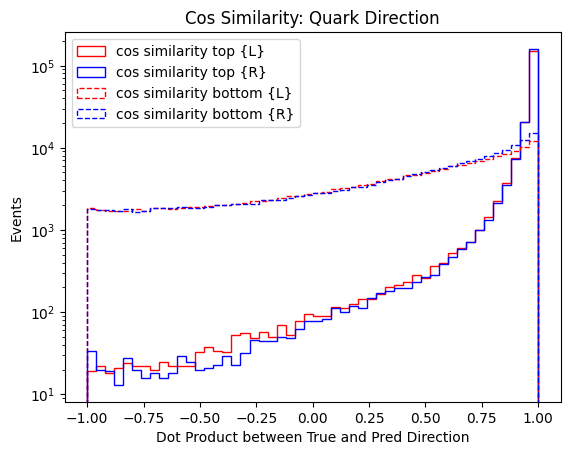

In [29]:
plt.title("Cos Similarity: Quark Direction")
plt.hist(cos_similarity_top_L,histtype='step',bins=50,range=(-1,1),color='r',label='cos similarity top {L}',linestyle="-")
plt.hist(cos_similarity_top_R,histtype='step',bins=50,range=(-1,1),color='b',label='cos similarity top {R}',linestyle="-")
plt.hist(cos_similarity_quark_L,histtype='step',bins=50,range=(-1,1),color='r',label='cos similarity bottom {L}',linestyle="--")
plt.hist(cos_similarity_quark_R,histtype='step',bins=50,range=(-1,1),color='b',label='cos similarity bottom {R}',linestyle="--")
plt.yscale('log')
plt.xlabel("Dot Product between True and Pred Direction")
plt.ylabel("Events")
plt.legend()
plt.show()

In [30]:
with open("results.root", "wb") as file:
    pickle.dump({"cos_theta_true_L": np.array(cos_theta_true_L), 
                       "cos_theta_pred_L": np.array(cos_theta_pred_L),
                       "cos_theta_true_R": np.array(cos_theta_true_R),
                       "cos_theta_pred_R": np.array(cos_theta_pred_R),
                      }, file)

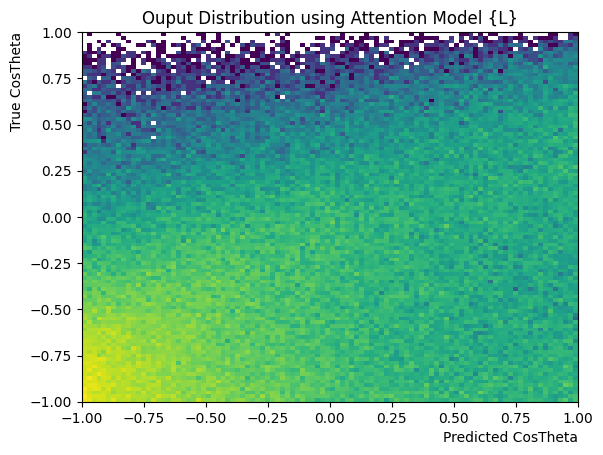

In [31]:
plt.figure()
plt.title("Ouput Distribution using Attention Model {L}")
plt.hist2d(np.array(cos_theta_pred_L),np.array(cos_theta_true_L),bins=100,norm=mcolors.LogNorm(),range=((-1,1),(-1,1)))
plt.xlabel('Predicted CosTheta',loc='right')
plt.ylabel('True CosTheta',loc='top')
#plt.text(1-0.3*2,1-0.8*2,"$R^2$ value: "+str(round(r2_score(np.ravel(cos_theta_pred_L),np.ravel(cos_theta_true_L)),3)),backgroundcolor='r',color='k')
#print("R^2 value: ", round(r2_score(cos_theta_pred_L,cos_theta_true_L),3))
#plt.savefig(out_dir+"/pred_2d_"+feats[i]+".png")
plt.show()
plt.close()

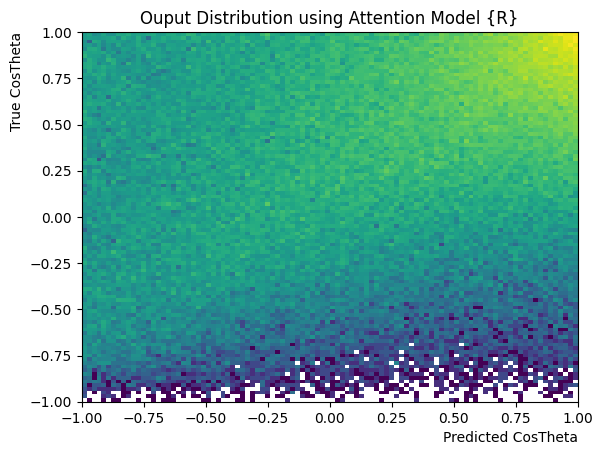

In [32]:
plt.figure()
plt.title("Ouput Distribution using Attention Model {R}")
plt.hist2d(np.array(cos_theta_pred_R),np.array(cos_theta_true_R),bins=100,norm=mcolors.LogNorm(),range=((-1,1),(-1,1)))
plt.xlabel('Predicted CosTheta',loc='right')
plt.ylabel('True CosTheta',loc='top')
#plt.text(1-0.3*2,1-0.8*2,"$R^2$ value: "+str(round(r2_score(np.ravel(cos_theta_pred_R),np.ravel(cos_theta_true_R)),3)),backgroundcolor='r',color='k')
#print("R^2 value: ", round(r2_score(cos_theta_pred_R,cos_theta_true_R),3))
#plt.savefig(out_dir+"/pred_2d_"+feats[i]+".png")
plt.show()
plt.close()

In [33]:
norm_true = np.sqrt(true_down_L[:,0]**2+true_down_L[:,1]**2+true_down_L[:,2]**2)
norm_pred = np.sqrt(pred_down_L[:,0]**2+pred_down_L[:,1]**2+pred_down_L[:,2]**2)

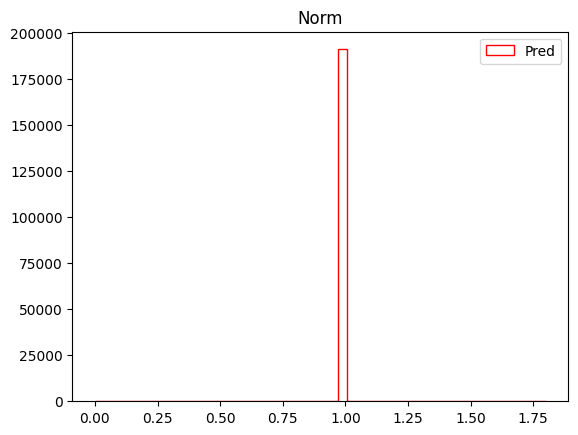

Mean:  0.9999999999573727
Std dev:  3.543773457589553e-08


In [34]:
plt.title("Norm")
#plt.hist(norm_true,histtype='step',bins=50,range=(0,1.4),color='k',label='True')
plt.hist(norm_pred,histtype='step',bins=50,range=(0,1.8),color='r',label='Pred')
plt.legend()
plt.show()
print("Mean: ", np.mean(norm_pred))
print("Std dev: ", np.std(norm_pred))

In [35]:
output = {
    "true_top_px_R": [],
    "true_top_py_R": [],
    "true_top_pz_R": [],
    
    "pred_top_px_R": [],
    "pred_top_py_R": [],
    "pred_top_pz_R": [],
    
    "true_down_px_R": [],
    "true_down_py_R": [],
    "true_down_pz_R": [],
    
    "pred_down_px_R": [],
    "pred_down_py_R": [],
    "pred_down_pz_R": [],
    
    "true_top_px_L": [],
    "true_top_py_L": [],
    "true_top_pz_L": [],
    
    "pred_top_px_L": [],
    "pred_top_py_L": [],
    "pred_top_pz_L": [],
    
    "true_down_px_L": [],
    "true_down_py_L": [],
    "true_down_pz_L": [],
    
    "pred_down_px_L": [],
    "pred_down_py_L": [],
    "pred_down_pz_L": [],
}

In [36]:
events = len(true_top_R)
for event in range(events):
    output["true_top_px_R"].append(true_top_R[event,0])
    output["true_top_py_R"].append(true_top_R[event,1])
    output["true_top_pz_R"].append(true_top_R[event,2])
    
    output["pred_top_px_R"].append(pred_top_R[event,0])
    output["pred_top_py_R"].append(pred_top_R[event,1])
    output["pred_top_pz_R"].append(pred_top_R[event,2])
    
    output["true_down_px_R"].append(true_down_R[event,0])
    output["true_down_py_R"].append(true_down_R[event,1])
    output["true_down_pz_R"].append(true_down_R[event,2])
    
    norm=1
        
    output["pred_down_px_R"].append(pred_down_R[event,0]/norm)
    output["pred_down_py_R"].append(pred_down_R[event,1]/norm)
    output["pred_down_pz_R"].append(pred_down_R[event,2]/norm)

In [37]:
events = len(true_top_L)
for event in range(events):
    output["true_top_px_L"].append(true_top_L[event,0])
    output["true_top_py_L"].append(true_top_L[event,1])
    output["true_top_pz_L"].append(true_top_L[event,2])
    
    output["pred_top_px_L"].append(pred_top_L[event,0])
    output["pred_top_py_L"].append(pred_top_L[event,1])
    output["pred_top_pz_L"].append(pred_top_L[event,2])
    
    output["true_down_px_L"].append(true_down_L[event,0])
    output["true_down_py_L"].append(true_down_L[event,1])
    output["true_down_pz_L"].append(true_down_L[event,2])
    
    norm=1
        
    output["pred_down_px_L"].append(pred_down_L[event,0]/norm)
    output["pred_down_py_L"].append(pred_down_L[event,1]/norm)
    output["pred_down_pz_L"].append(pred_down_L[event,2]/norm)

In [38]:
for key in output.keys():
    output[key] = np.array(output[key])

In [39]:
with open("output.pkl","wb") as f:
    pickle.dump(output, f)